# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf
import warnings
from sklearn.metrics import r2_score

from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,ZeroPadding2D,Activation,BatchNormalization,Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV,KFold
from scikeras.wrappers import KerasRegressor 

warnings.filterwarnings('ignore')

# Link of the used datasets: 

https://www.kaggle.com/datasets/abhikjha/utk-face-cropped

https://www.kaggle.com/datasets/mariafrenti/age-prediction

In [25]:
image_dir = Path('utkcropped/')

# Create File DataFrame

In [26]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series([int(i.split('\\')[-1].split('_')[0]) for i in filepaths], name='Age')

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [27]:
images

,Filepath,Age
0,utkcropped\62_0_2_20170112205718780.jpg.chip.jpg,62
1,utkcropped\26_0_1_20170116235506865.jpg.chip.jpg,26
2,utkcropped\80_0_0_20170111210128898.jpg.chip.jpg,80
3,utkcropped\1_0_2_20161219204858548.jpg.chip.jpg,1
4,utkcropped\20_1_1_20170116162433766.jpg.chip.jpg,20
...,...,...
22784,utkcropped\32_0_2_20170116163341710.jpg.chip.jpg,32
22785,utkcropped\50_1_0_20170113210319697.jpg.chip.jpg,50
22786,utkcropped\25_1_2_20170116174845535.jpg.chip.jpg,25
22787,utkcropped\35_0_0_20170120221059452.jpg.chip.jpg,35


# Working with multiple variations of the dataset

In [28]:
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns

In [29]:
images.reset_index(drop=True, inplace=True)

images.head()

,Filepath,Age
0,utkcropped\62_0_2_20170112205718780.jpg.chip.jpg,62
1,utkcropped\26_0_1_20170116235506865.jpg.chip.jpg,26
2,utkcropped\80_0_0_20170111210128898.jpg.chip.jpg,80
3,utkcropped\1_0_2_20161219204858548.jpg.chip.jpg,1
4,utkcropped\20_1_1_20170116162433766.jpg.chip.jpg,20


# Visualizing Function to show image

In [30]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

Age: 23


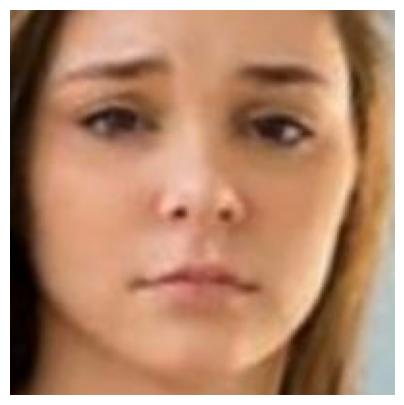

In [31]:
image_id = 13000
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

# Working with the whole dataset

In [32]:
sampled_df1 = images

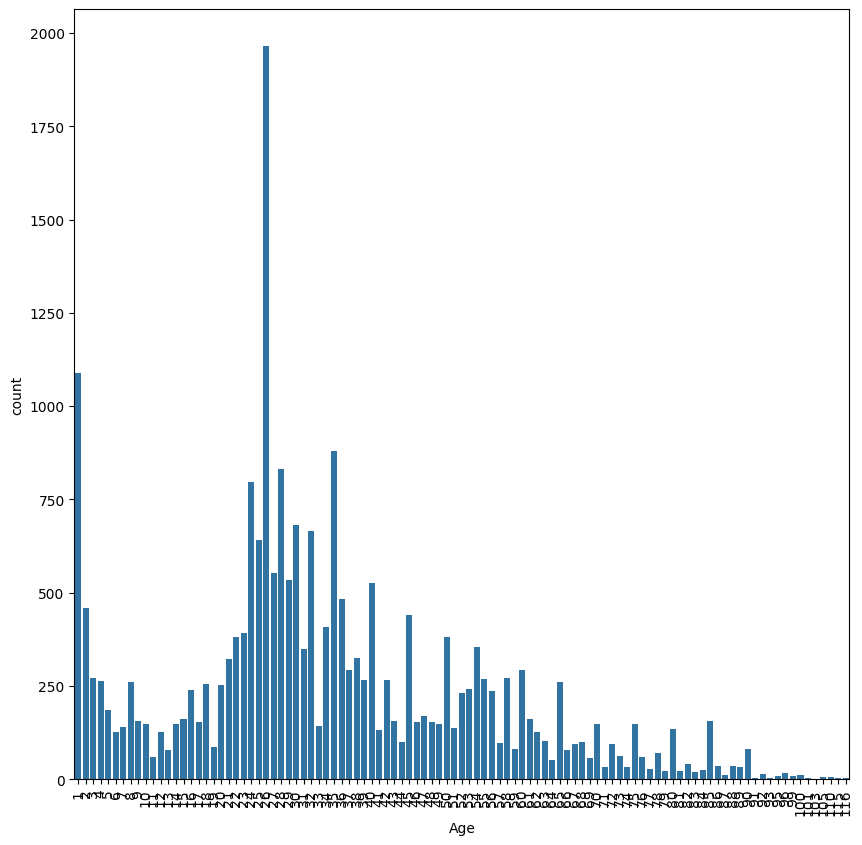

In [33]:
plt.figure(figsize=(10, 10))
sns.countplot(data=sampled_df1, x='Age')
plt.xticks(rotation = 90)
plt.show()

In [34]:
image_df = sampled_df1.reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [35]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [36]:
def make_model(): # make new instance of the model too add different data
    inputs = tf.keras.Input(shape=(200, 200, 3))
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def show_plotly(history): # show the model's training over the epochs
    import plotly.express as px
    fig = px.line(
        history.history,
        y=['loss', 'val_loss'],
        labels={'index': "Epoch", 'value': "Loss"},
        title="Model"
    )

    fig.show()

def print_scores(model, test_images): # show the model's score after the training
    predicted_ages = np.squeeze(model.predict(test_images))
    true_ages = test_images.labels

    rmse = np.sqrt(model.evaluate(test_images, verbose=0))

    r2 = r2_score(true_ages, predicted_ages)

    print("Root Mean Squared Error: {}".format(rmse))

    print("R Squared score: {}".format(r2))

In [37]:
make_model().summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,049 (117.38 KB)

 Trainable params: 30,049 (117.38 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 12762 validated image filenames.
Found 3190 validated image filenames.
Found 6837 validated image filenames.


In [39]:
model1 = make_model()

model1.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

history = model1.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 49s 120ms/step - loss: 20.8281 - mean_squared_error: 728.3534 - val_loss: 15.4435 - val_mean_squared_error: 420.1977
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - loss: 16.4659 - mean_squared_error: 463.6212 - val_loss: 15.1287 - val_mean_squared_error: 397.4061
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 47s 118ms/step - loss: 15.8381 - mean_squared_error: 439.0169 - val_loss: 15.0449 - val_mean_squared_error: 402.8084
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - loss: 15.5055 - mean_squared_error: 421.3519 - val_loss: 14.9263 - val_mean_squared_error: 400.5532
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - loss: 15.4356 - mean_squared_error: 412.6697 - val_loss: 14.4791 - val_mean_squared_error: 361.8573
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - loss: 15.3506 - mean_squared_error: 415.5488 - val_loss: 15.9356 - val_mean_squared_error: 448.7308
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - l

In [40]:
show_plotly(history)

In [41]:
print_scores(model1, test_images)

214/214 ━━━━━━━━━━━━━━━━━━━━ 36s 169ms/step
Root Mean Squared Error: [ 3.80433594 19.28816542]
R Squared score: 0.06660156012834773


# Working with ages between `1` and `70`

In [42]:
sampled_df2 = images[(images["Age"] >= 1) & (images["Age"] <= 70)]

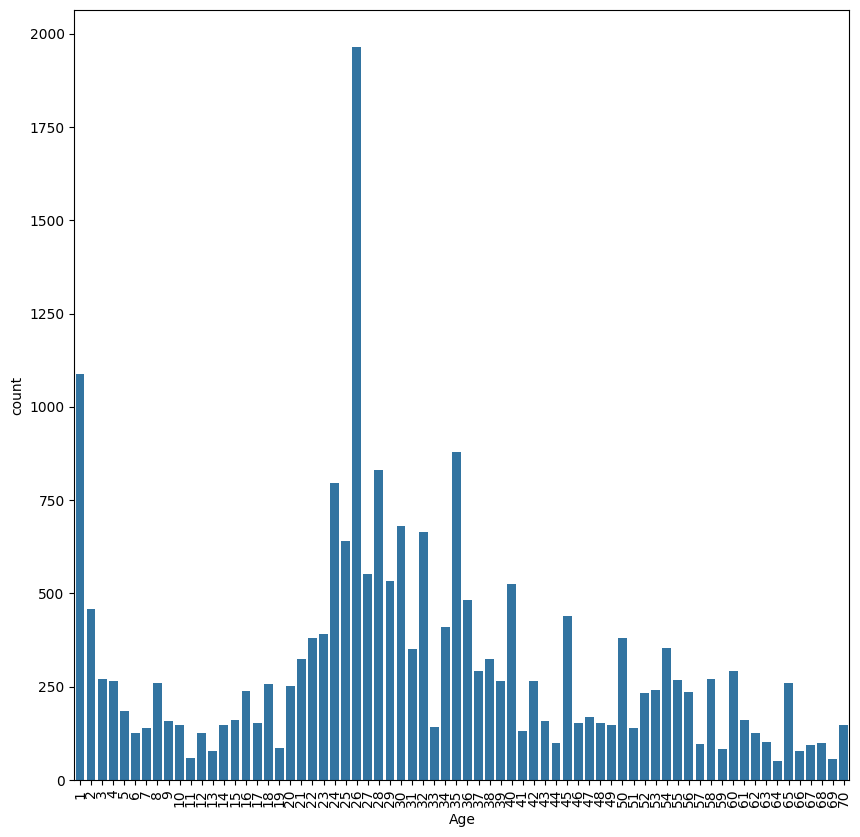

In [43]:
plt.figure(figsize=(10, 10))
sns.countplot(data=sampled_df2, x='Age')
plt.xticks(rotation = 90)
plt.show()

In [44]:
image_df = sampled_df2.reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [45]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [46]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 12082 validated image filenames.
Found 3020 validated image filenames.
Found 6473 validated image filenames.


In [47]:
model2 = make_model()

model2.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

history = model2.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - loss: 18.7067 - mean_squared_error: 563.8873 - val_loss: 13.5246 - val_mean_squared_error: 298.0500
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - loss: 13.6064 - mean_squared_error: 304.6265 - val_loss: 13.4750 - val_mean_squared_error: 307.8251
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - loss: 13.5583 - mean_squared_error: 298.8197 - val_loss: 13.4197 - val_mean_squared_error: 282.7863
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - loss: 13.3215 - mean_squared_error: 291.3545 - val_loss: 13.0425 - val_mean_squared_error: 281.3690
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - loss: 13.3480 - mean_squared_error: 292.0483 - val_loss: 13.0263 - val_mean_squared_error: 285.3695
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - loss: 13.0927 - mean_squared_error: 282.3225 - val_loss: 13.2341 - val_mean_squared_error: 277.0332
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - l

In [48]:
show_plotly(history)

In [49]:
print_scores(model2, test_images)

203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step
Root Mean Squared Error: [ 3.54487574 16.20823396]
R Squared score: 0.09193916450279627


# Working with age between `1` and `50`

In [50]:
sampled_df3 = images[(images["Age"] >= 1) & (images["Age"] <= 50)]

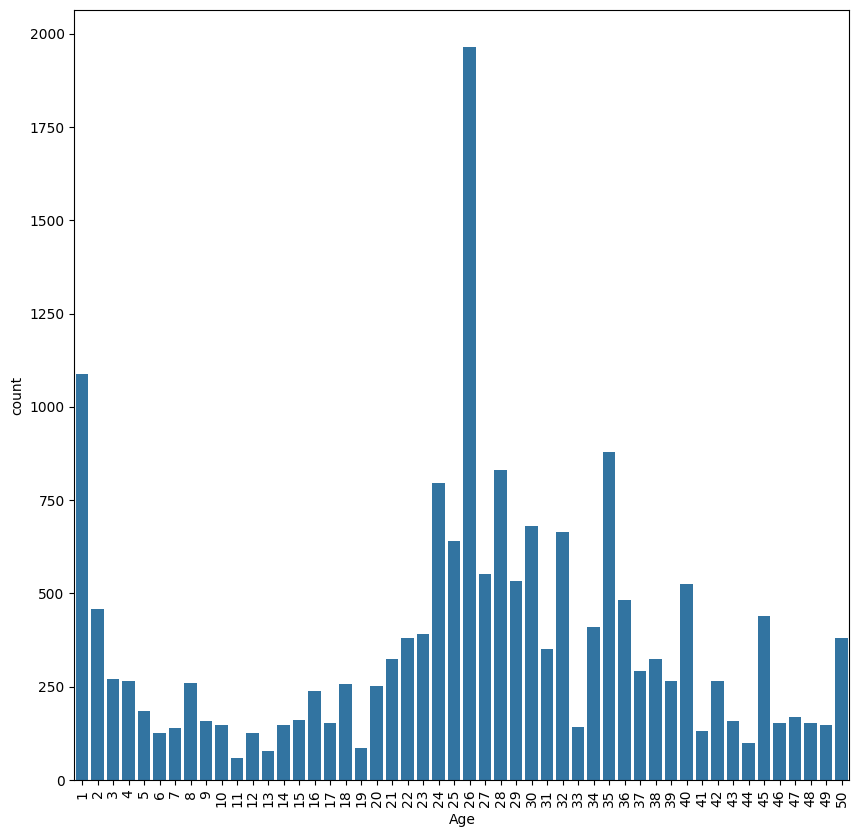

In [51]:
plt.figure(figsize=(10, 10))
sns.countplot(data=sampled_df3, x='Age')
plt.xticks(rotation = 90)
plt.show()

In [52]:
image_df = sampled_df3.reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [53]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [54]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 10187 validated image filenames.
Found 2546 validated image filenames.
Found 5458 validated image filenames.


In [55]:
model3 = make_model()

model3.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

history = model3.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - loss: 15.4108 - mean_squared_error: 370.5988 - val_loss: 9.7462 - val_mean_squared_error: 158.9958
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - loss: 10.6123 - mean_squared_error: 177.4483 - val_loss: 9.5658 - val_mean_squared_error: 147.6911
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - loss: 10.6624 - mean_squared_error: 176.1089 - val_loss: 9.7060 - val_mean_squared_error: 155.3450
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 10.4481 - mean_squared_error: 170.6227 - val_loss: 9.7614 - val_mean_squared_error: 148.7419
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - loss: 10.5152 - mean_squared_error: 172.3994 - val_loss: 10.3189 - val_mean_squared_error: 160.2091
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 10.3424 - mean_squared_error: 167.1743 - val_loss: 9.4958 - val_mean_squared_error: 147.3726
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 

In [56]:
show_plotly(history)

In [57]:
print_scores(model3, test_images)

171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
Root Mean Squared Error: [ 3.06950605 12.21337085]
R Squared score: 0.09265648921790492


# Working ages between `20` and `50`

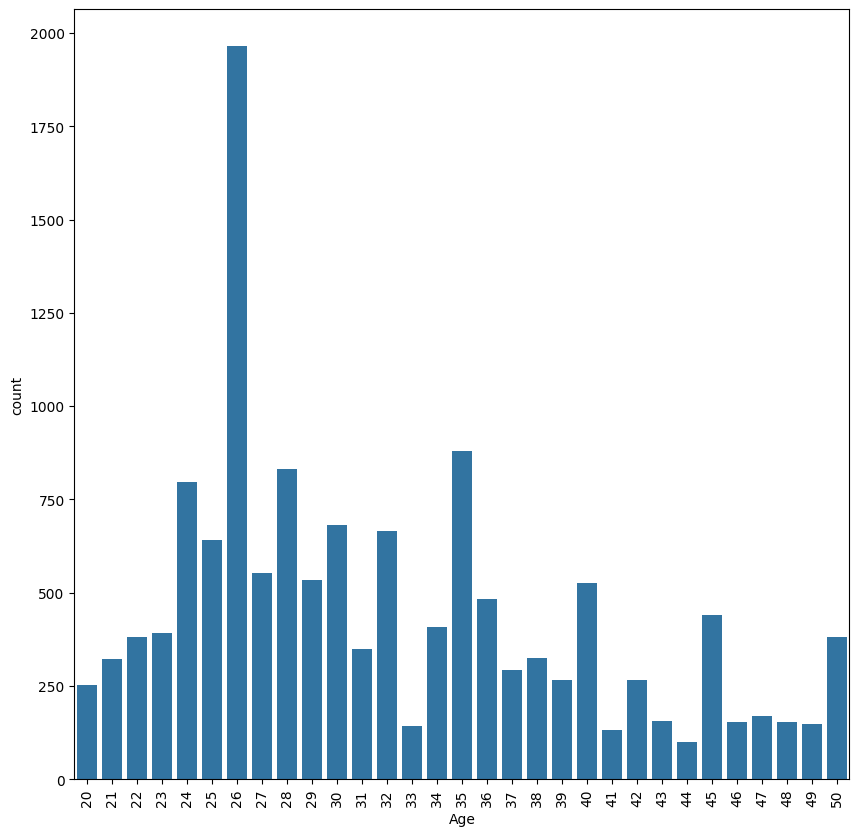

In [58]:
sampled_df4 = images[(images["Age"] >= 20) & (images["Age"] <= 50)]

plt.figure(figsize=(10, 10))
sns.countplot(data=sampled_df4, x='Age')
plt.xticks(rotation = 90)
plt.show()

In [59]:
image_df = sampled_df4.reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [60]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [61]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 7721 validated image filenames.
Found 1930 validated image filenames.
Found 4137 validated image filenames.


In [62]:
model4 = make_model()

model4.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

history = model4.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - loss: 15.3579 - mean_squared_error: 376.7576 - val_loss: 7.5029 - val_mean_squared_error: 91.2859
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - loss: 7.7665 - mean_squared_error: 96.2960 - val_loss: 6.8572 - val_mean_squared_error: 81.1495
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - loss: 7.4447 - mean_squared_error: 89.1321 - val_loss: 6.7212 - val_mean_squared_error: 80.5705
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - loss: 7.2251 - mean_squared_error: 83.5386 - val_loss: 6.3260 - val_mean_squared_error: 63.4420
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - loss: 7.2073 - mean_squared_error: 83.8513 - val_loss: 6.4003 - val_mean_squared_error: 58.1939
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - loss: 7.0655 - mean_squared_error: 80.2638 - val_loss: 6.2508 - val_mean_squared_error: 60.2852
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - loss: 7.0644 - mean_squ

In [63]:
show_plotly(history)

In [64]:
print_scores(model4, test_images)

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
Root Mean Squared Error: [2.49709485 7.69181467]
R Squared score: 0.042665843212322474


In [65]:
sampled_df4["Age"].value_counts().min()

100

# working with only a balanced sample of the data between `20` and `50`

In [66]:
def sample_100(group):
    return group.sample(n=min(100, group.shape[0]))

sampled_df = sampled_df4.groupby('Age', group_keys=False).apply(sample_100)

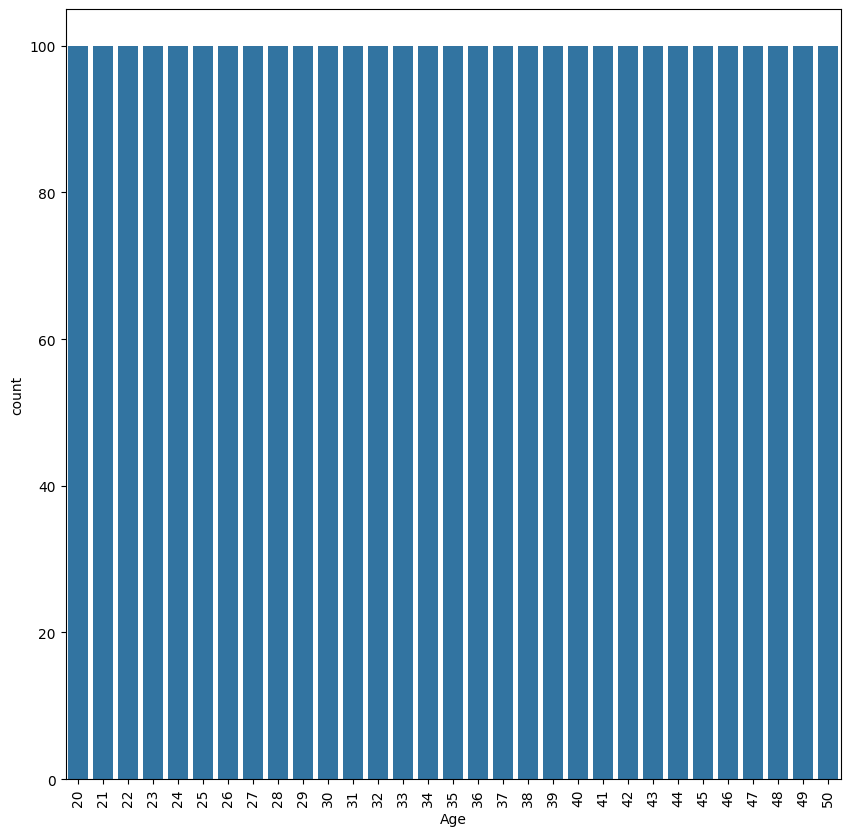

In [67]:
plt.figure(figsize=(10, 10))
sns.countplot(data=sampled_df, x='Age')
plt.xticks(rotation = 90)
plt.show()

In [68]:
len(sampled_df)

3100

In [69]:
image_df = sampled_df.reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [70]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [71]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(200, 200),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 1736 validated image filenames.
Found 434 validated image filenames.
Found 930 validated image filenames.


In [72]:
model5 = make_model()

model5.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

history = model5.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 28.0424 - mean_squared_error: 943.8324 - val_loss: 9.2096 - val_mean_squared_error: 121.7078
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 10.0304 - mean_squared_error: 145.1641 - val_loss: 9.0532 - val_mean_squared_error: 117.0231
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 9.6651 - mean_squared_error: 137.7180 - val_loss: 9.4713 - val_mean_squared_error: 129.8997
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 9.3334 - mean_squared_error: 128.6786 - val_loss: 8.7208 - val_mean_squared_error: 106.2469
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 8.9050 - mean_squared_error: 116.4107 - val_loss: 8.5973 - val_mean_squared_error: 103.4630
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 9.2667 - mean_squared_error: 122.9103 - val_loss: 8.5034 - val_mean_squared_error: 99.4556
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 9.1783 - mean_squared_error

In [73]:
show_plotly(history)

In [74]:
print_scores(model5, test_images)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Root Mean Squared Error: [2.80624686 9.2893323 ]
R Squared score: -0.11372345159472474


In [ ]:
def create_model(conv_layers=1, neuron1=16, neuron2=16, dropout_rate=0.2, learning_rate=0.01, epochs=10):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(200,200,3), padding='Same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    fl = 140
    for _ in range(conv_layers-1):
        model.add(Conv2D(fl, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        fl-=20
    model.add(Flatten())
    model.add(Dense(neuron1, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2,activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

    inputs = tf.keras.Input(shape=(200, 200, 3))
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPool2D()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPool2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

param_grid = {
    'conv_layers': [1, 2],
    'neuron1' : [8, 16, 32],
    'neuron2' : [16, 32, 64],
    'dropout_rate': [0.5, 0.3],
    'learning_rate': [0.001, 0.01],
    'epochs': [10, 20]
}

model = KerasRegressor(build_fn=create_model, verbose=0, conv_layers=1, neuron1=8, neuron2=16, dropout_rate=0.5, learning_rate=0.001, epochs=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=3, shuffle=True,random_state=6))
grid_result = grid.fit(X_train,y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print("%f (%f) with: %r" % (mean, param))

# Trying out some outsider images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


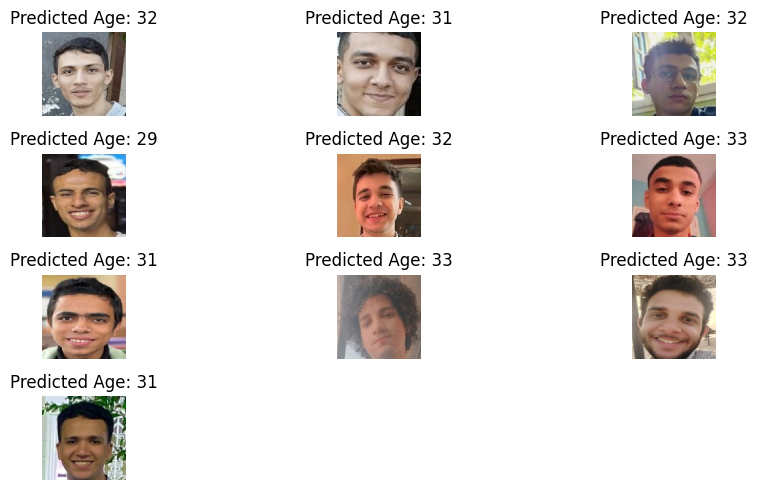

In [84]:
import os
import matplotlib.pyplot as plt
import numpy as np

def process_images_in_directory(directory_path, model):

    image_files = [file for file in os.listdir(directory_path) if file.lower().endswith(('.jpg', '.png'))]

    num_images = len(image_files)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(9, 5))

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory_path, image_file)
        image_test = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200))
        input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image_test)]).astype('float32') / 255
        predictions = model.predict(input_arr)
        predicted_age = predictions[0][0].astype(np.int32).astype(str)

        ax = axs[i // num_cols, i % num_cols]
        ax.imshow(image_test)
        ax.set_title(f'Predicted Age: {predicted_age}')
        ax.axis('off')

    for j in range(num_images, num_rows * num_cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()

directory_path = r"C:\Users\bodyk\Downloads\NN Team"
process_images_in_directory(directory_path, model4)

# image_path = r"C:\Users\bodyk\Downloads\NN Team\Hesham.jpg"
# image_test = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200))
# input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image_test)]).astype(float) / 255
# predictions = model.predict(input_arr)
# predicted_age = predictions[0][0].astype(np.int32).astype(str)

# plt.imshow(image_test)
# plt.title(f'Predicted Age: {eval(predicted_age)}')
# plt.axis('off')

# Preserving the best model

In [83]:
import keras
keras.saving.save_model(model4, "model.h5")

model4.save_weights("weights.weights.h5")